In [1]:
import pandas as pd
import numpy as np
from my_pysyncon import Dataprep, Synth, AugSynth
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import empirical_covariance

In [2]:
# import the data
df_mo = pd.read_csv('../../../SharedData/total_state_data.csv')

# this list is used to make certain columns later
abbreviations = [
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA",
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD",
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC",
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
]

# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of emissions program (CA, WA)
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']
other_states = ['AK', 'HI', 'CA', 'WA']
non_rggi_controls_identifier = list(set(abbreviations) - set(rggi_states) - set(other_states))

# DC isn't a state (sorry not sorry)
df_mo = df_mo[df_mo.state != 'DC']

# add a bunch of features (these will eventually get moved to combine_files.ipynb)
df_mo['co2_per_capita'] = df_mo['monthly_emissions'] / df_mo['monthly_population']
df_mo['gdp_per_capita'] = df_mo['gdp_rel_2017_interp'] / df_mo['monthly_population']
df_mo['eprod_per_capita'] = df_mo['monthly_energy_prod'] / df_mo['monthly_population']
df_mo['eflow_per_capita'] = df_mo['monthly_energy_flow'] / df_mo['monthly_population']
df_mo['euse_per_capita'] = df_mo['monthly_energy_use'] / df_mo['monthly_population']
#df_mo['num_plants_per_capita'] = df_mo['monthly_num_plants'] / df_mo['monthly_population']

In [3]:
# create column for simple moving avg of co2_per_capita; ma_window is the moving average window size (n=1 corresponds to usual monthly results)
df_mo['co2_per_capita_sma'] = np.nan

ma_window = 24
for state in abbreviations:
    df_mo.loc[df_mo.state==state,'co2_per_capita_sma'] = df_mo.loc[df_mo.state==state,'co2_per_capita'].rolling(window=ma_window).mean()

In [4]:
# set number of months to skip at a time when training monthly model.
# month_jumps = 1 means consider all monthly data; month_jumps = 12 means consider one month per year
month_jumps = 1

treatment_date = '2009-01-01'
preintervention_ma_start_date = str((pd.to_datetime('1991-01-01')+ pd.DateOffset(months=ma_window-1)).strftime('%Y-%m-%d'))

# these are the time values where CO2 per capita is fit
preintervention_time_range = df_mo.date[(df_mo.date >= '1991-01-01')&(df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]

# these are the time values where our features are fit (subset of preintervention_time_range)
preintervention_feature_range = df_mo.date[(df_mo.date >= '1997-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_weather_range = df_mo.date[(df_mo.date >= '1991-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_gdp_range = df_mo.date[(df_mo.date >= '1997-12-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_per_capita_range = df_mo.date[(df_mo.date >= '1991-06-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_energy_range = df_mo.date[(df_mo.date >= '1991-01-01') & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]
preintervention_ma_range = df_mo.date[(df_mo.date >= preintervention_ma_start_date) & (df_mo.date<treatment_date)&(df_mo.state=='MI')][::month_jumps]


# these are the dates used for our monthly_emissions graph
years = pd.date_range(start='1991-01-01', end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

# these are the dates used for our monthly_emissions SMA graph
years_sma = pd.date_range(start=preintervention_ma_start_date, end='2019-12-01', freq='MS').strftime('%Y-%m-%d').tolist()[::month_jumps]

In [5]:
state_id = 'DE'

predictors = ['co2_per_capita_sma', 'monthly_num_plants']
special_predictors=[('eprod_per_capita', preintervention_energy_range, "mean"),
                    ('eflow_per_capita', preintervention_energy_range, "mean"),
                    # ('euse_per_capita', preintervention_energy_range, "mean"),
                    # ('gdp_per_capita', preintervention_gdp_range, "mean"),
                    ('monthly_pop_density', preintervention_per_capita_range, "mean"),
                    # ('snow', preintervention_weather_range, 'mean'),
                    # ('tavg', preintervention_weather_range, 'mean'),
                    # ('prcp', preintervention_weather_range, 'mean'),
                    ('yearly_renew_pct', preintervention_energy_range, "mean"),
                    ('yearly_fossil_pct', preintervention_energy_range, "mean")
                    ]


In [6]:
# we create a synthetic control Delaware as applied to monthly_emissions SMA data
dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=predictors,
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=special_predictors,
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state_id,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )
    
synth_mo_ma = Synth()
synth_mo_ma.fit(dataprep=dataprep_mo_ma)
print("Monthly SMA Model, window", ma_window, ":")
print(synth_mo_ma.weights(threshold=.01))
print("Loss V:", synth_mo_ma.loss_V)
print("Loss W:", synth_mo_ma.loss_W)

Monthly SMA Model, window 24 :
NV    0.147
CO    0.853
Name: weights, dtype: float64
Loss V: 0.019576354881864075
Loss W: -2.2307454628113046


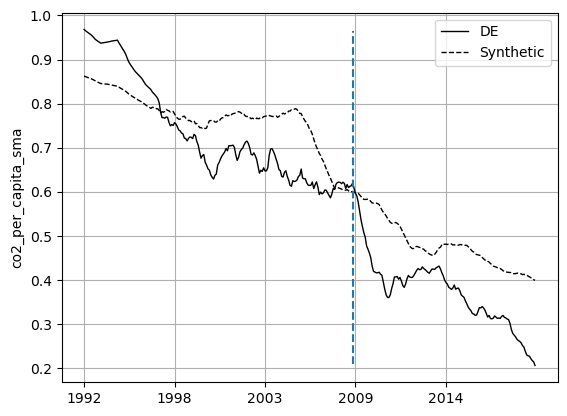

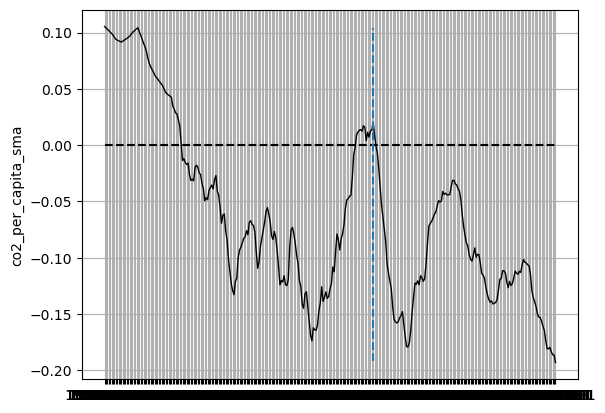

In [35]:
# these lists are used for treatment_time in graphs below
treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

# Monthly_emissions SMA synthetic control plot
synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

NY
FL    0.373
OR    0.260
IL    0.367
Name: weights, dtype: float64
Loss V: 0.07453874919080833
Loss W: -0.8294034577720998


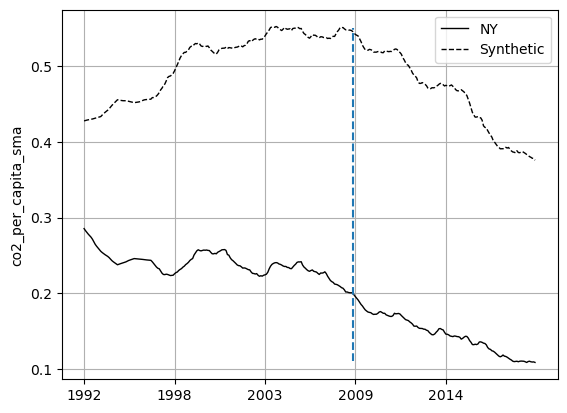

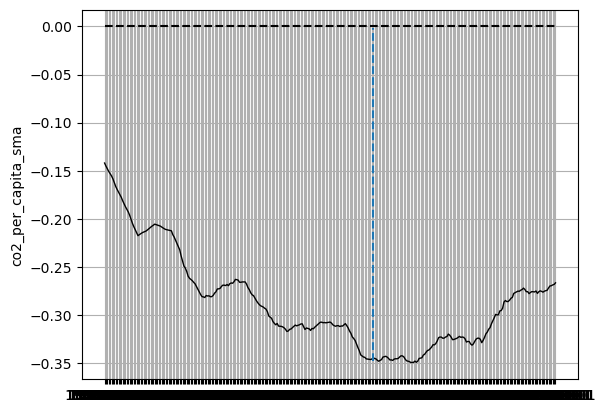

DE
NV    0.147
CO    0.853
Name: weights, dtype: float64
Loss V: 0.01957635488051315
Loss W: -2.2307468030056663


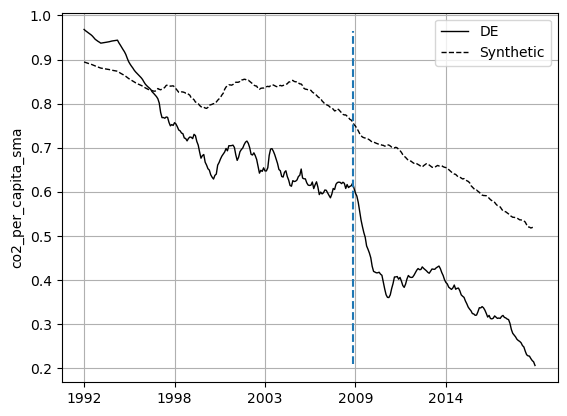

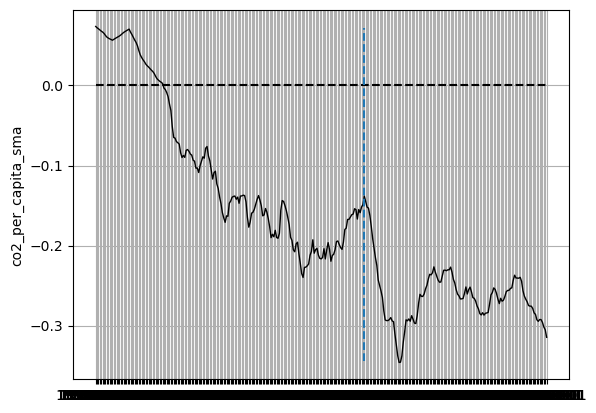

TX
PA    1.0
Name: weights, dtype: float64
Loss V: 0.025370248809409936
Loss W: -2.7296901373287987


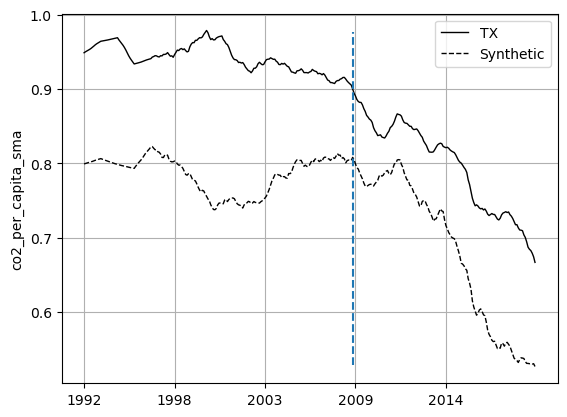

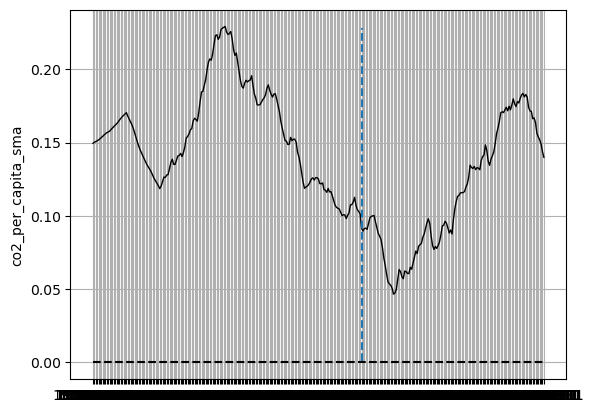

In [39]:
# these lists are used for treatment_time in graphs below
treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

test_states = {"DE", "NY"}
for state_id in test_states:
    # we create a synthetic control Delaware as applied to monthly_emissions SMA data
    dataprep_mo_ma = Dataprep(
        foo=df_mo,
        predictors=predictors,
        predictors_op="mean",
        time_predictors_prior=preintervention_feature_range,
        special_predictors=special_predictors,
        dependent="co2_per_capita_sma",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state_id,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )
    
    synth_mo_ma = Synth()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)
    print(state_id)
    print(synth_mo_ma.weights(threshold=.01))
    print("Loss V:", synth_mo_ma.loss_V)
    print("Loss W:", synth_mo_ma.loss_W)

    # Monthly_emissions SMA synthetic control plot
    synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])



state_id = "TX"
non_tx_controls_identifier = list(set(non_rggi_controls_identifier) - set(['TX']))

dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=predictors,
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=special_predictors,
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state_id,
    controls_identifier= non_tx_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

synth_mo_ma = Synth()
synth_mo_ma.fit(dataprep=dataprep_mo_ma)
print(state_id)
print(synth_mo_ma.weights(threshold=.01))
print("Loss V:", synth_mo_ma.loss_V)
print("Loss W:", synth_mo_ma.loss_W)

# Monthly_emissions SMA synthetic control plot
synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])


## PCA Calculation

In [ ]:
# separate df_mo into two pieces
non_pca_cols = df_mo[(df_mo.date >= '1990-11')&(df_mo.date <='2019-12-01')][['state','date','co2_per_capita_sma','gdp_per_capita','monthly_num_plants']]
num_cols = df_mo[(df_mo.date>=preintervention_ma_start_date) & (df_mo.date<=treatment_date)].drop(columns=['state','date','co2_per_capita_sma'])
# drop outcomes for PCA; 
# drop weather data because too many missing values
# drop GDP and num_plants because only have data for 1997-
# drop yearly data because this is PCA for monthly model
# drop non-per-capita versions of per-capita data to reduce redundancy
# drop non-density versions of data to reduce redundancy
df_mo_pca = num_cols[['yearly_renew_pct', 'yearly_fossil_pct','monthly_pop_density','eprod_per_capita','eflow_per_capita']]
print('number of features before PCA calculation is',len(df_mo_pca.columns))

# save the indices to be used later in pca_df
df_mo_pca_indices = df_mo_pca.index

# make covariance matrix to see how features are correlated
# empirical_covariance(df_mo_pca)

number of features before PCA calculation is 5


array([[ 0.0434212 , -0.03524671,  0.00229008, -0.00307011, -0.00257282],
       [-0.03524671,  0.06461835,  0.00082609,  0.01074431,  0.00968905],
       [ 0.00229008,  0.00082609,  0.00160951,  0.00461666,  0.00440854],
       [-0.00307011,  0.01074431,  0.00461666,  0.03205512,  0.03082799],
       [-0.00257282,  0.00968905,  0.00440854,  0.03082799,  0.02973453]])

In [ ]:
# # We'll use PCA to make the covariates independent (which I think is an underlying assumption of a diagonal V)
# # Standardize the covariates
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(df_mo_pca)

# # Apply PCA
# n_components = 5
# pca = PCA(n_components=n_components)
# X_pca = pca.fit_transform(X_scaled)


# # Add the state and date back
# pca_col_names = ['PCA'+str(i) for i in range(1,n_components+1)]
# pca_df = pd.DataFrame(X_pca, columns=pca_col_names)
# cov_mat = empirical_covariance(pca_df)
# cov_mat[np.abs(cov_mat)<10**(-5)]=0
# np.set_printoptions(suppress=True)
# # print('Percent of total variance from each component:', np.diag(cov_mat)/np.trace(cov_mat)*100)

This suggests that we only need 4 components (since the 5th component composes 0.026% of total variance). So let's redo the PCA with n_components = 4.

In [136]:
# We'll use PCA to make the covariates independent (which I think is an underlying assumption of a diagonal V)
# Standardize the covariates
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_mo_pca)

# Apply PCA
n_components = 4
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Add the state and date back
pca_col_names = ['PCA'+str(i) for i in range(1,n_components+1)]
pca_df = pd.DataFrame(X_pca, columns=pca_col_names)
pca_df.index = df_mo_pca_indices
cov_mat = empirical_covariance(pca_df)
cov_mat[np.abs(cov_mat)<10**(-5)]=0
np.set_printoptions(suppress=True)
print('Percent of total variance from each component:', np.diag(cov_mat)/np.trace(cov_mat)*100)


merged_pca_df = pca_df.merge(non_pca_cols, left_index=True, right_index=True, how='right')

Percent of total variance from each component: [52.07624785 33.76337337  9.87410786  4.28627092]


We prepare the study data using a `Dataprep` object that describes all the details needed to define the synthetic control study. This works similarly to the `dataprep` method in the `R` package `synth`.

(For an explanation of each of the `Dataprep` arguments, see the package [documentation](https://sdfordham.github.io/pysyncon/dataprep.html#pysyncon.Dataprep)).

In [137]:
# we leave off RGGI states, states with no CO2 data (AK, HI), as well as states with some type of emissions program (CA, WA)
rggi_states = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'RI', 'VT', 'VA']
other_states = ['AK', 'HI', 'CA', 'WA']

non_rggi_controls_identifier = list(set(abbreviations) - set(rggi_states) - set(other_states))

assert(len(non_rggi_controls_identifier) + len(other_states) + len(rggi_states) == 50)

In [138]:
# we create a synthetic control Delaware as applied to monthly_emissions data
dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['co2_per_capita', 'monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )
    
# we create a synthetic control Delaware as applied to monthly_emissions SMA data
dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=['co2_per_capita_sma', 'monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

# we create a synthetic control Delaware as applied to monthly_emissions SMA PCA data
dataprep_mo_ma_pca = Dataprep(
    foo=merged_pca_df,
    predictors=pca_col_names+['co2_per_capita_sma', 'monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )


We supply the `Dataprep` object to a `Synth` object. The optimization scheme we could use is [BFGS](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-bfgs.html) and the starting point we could use for the optimisation is `ols` i.e. the initial weights are obtained by fitting an ordinary-least-squares estimate. (Unlike the `R` package `synth` which performs four different runs under the hood (two different starting points and two different optimisation schemes), in this package only one optimisation is run per `fit`).

*Nota bene that the weights obtained by the synthetic control method are often highly sensitive to the chosen optimisation scheme and starting point.*

In [ ]:
# loss_V represents the MSPE (mean squared prediction error) PRIOR to treatment
# loss_V incorporates matrix of weights W and CO2 outcomes
# loss_W incorporates covariates (predictors) and constraint of weights summing to 1
# best values of loss_W are close to 0 (but loss_V is more consequential for us!)

# # monthly_emissions version
# synth_mo = Synth()
# synth_mo.fit(dataprep=dataprep_mo)
# print("Monthly:")
# print(synth_mo.weights(threshold=.01))
# print(synth_mo.loss_V)
# print()

# monthly_emissions SMA version
synth_mo_ma = Synth()
synth_mo_ma.fit(dataprep=dataprep_mo_ma)
print("Monthly SMA:")
print(synth_mo_ma.weights(threshold=.01))
print(synth_mo_ma.loss_V)
print()

# # monthly_emissions SMA PCA version
# synth_mo_ma_pca = Synth()
# synth_mo_ma_pca.fit(dataprep=dataprep_mo_ma_pca)
# print("Monthly SMA PCA:")
# print(synth_mo_ma_pca.weights(threshold=.01))
# print(synth_mo_ma_pca.loss_V)

Monthly:
NV    0.472
IL    0.238
MN    0.290
Name: weights, dtype: float64
0.03456129122728709

Monthly SMA:
NV    0.443
MN    0.557
Name: weights, dtype: float64
0.00994819809101275

Monthly SMA PCA:
NV    0.468
IL    0.109
MN    0.422
Name: weights, dtype: float64
0.010430012061385907


In [115]:
# these lists are used for treatment_time in graphs below

treatment_dates = []
for year in years:
    if year.startswith('2009'):
        treatment_dates.append(year)

treatment_dates_ma = []
for year in years_sma:
    if year.startswith('2009'):
        treatment_dates_ma.append(year)

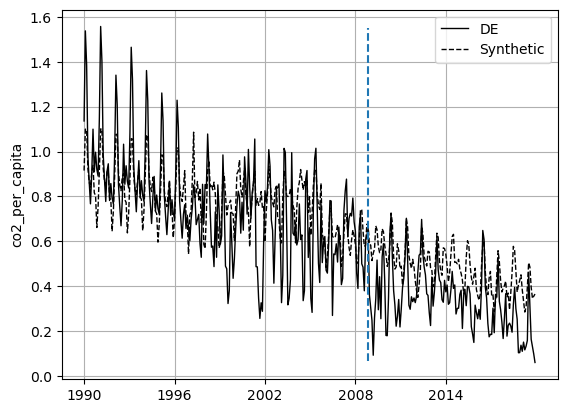

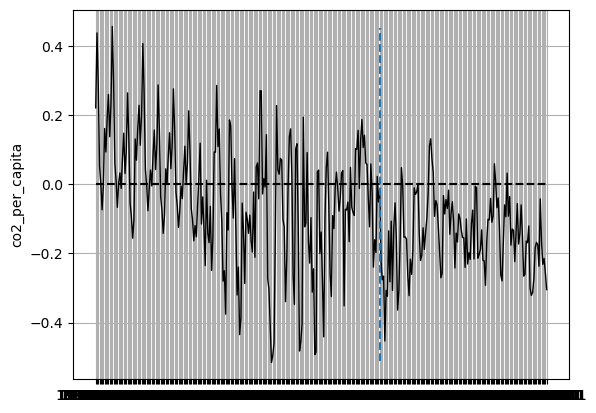

In [116]:
# Monthly_emissions synthetic control plot

synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])

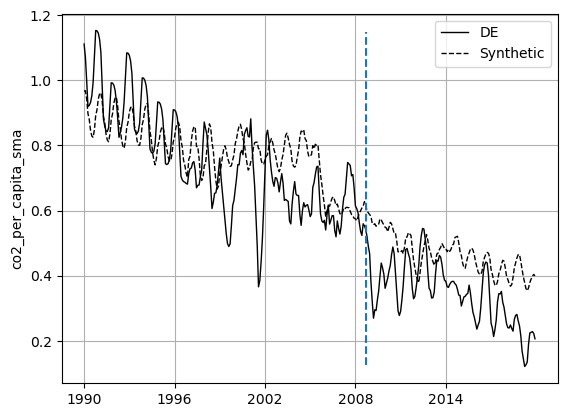

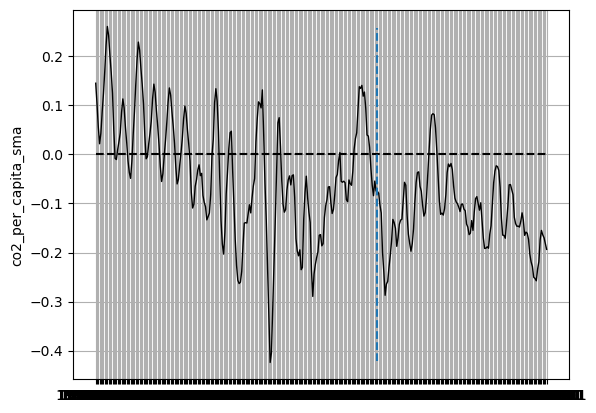

In [117]:
# Monthly_emissions SMA synthetic control plot

synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

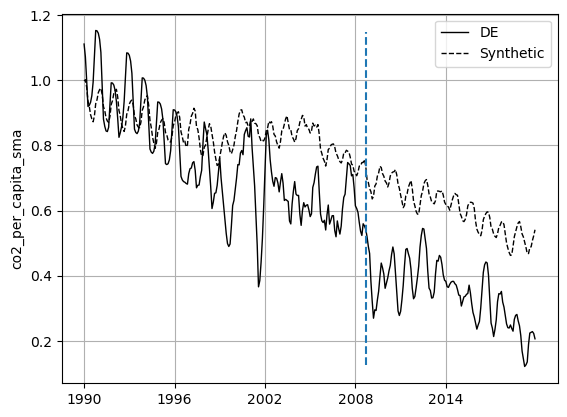

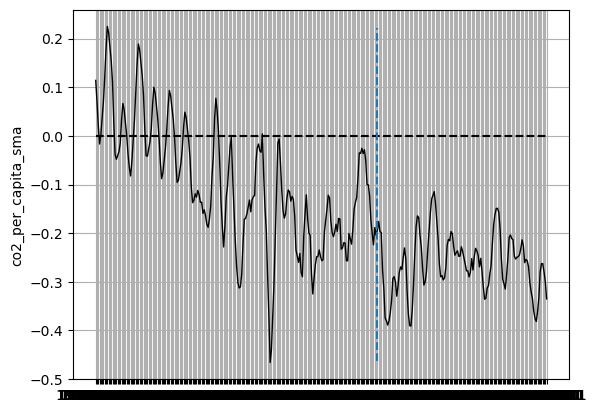

In [118]:
synth_mo_ma_pca.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
synth_mo_ma_pca.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

The summary function give more information on the predictor values. The first column shows the value of the $V$ matrix for each predictor, the column 'treated' shows the mean value of each predictor for the treated unit over the time period `time_predictors_prior`, the column 'synthetic' shows the mean value of each predictor for the synthetic control over the time period `time_predictors_prior` and finally the column 'sample mean' shows the sample mean of that predictor for all control units over the time period `time_predictors_prior` i.e. this is the same as the synthetic control with all weights equal.

In [119]:
synth_mo.summary()

,V,treated,synthetic,sample mean
co2_per_capita,0.044,0.656,0.745,1.375
monthly_num_plants,0.146,7.840,19.496,21.660
special.1.eprod_per_capita,0.078,0.000,0.005,0.064
special.2.eflow_per_capita,0.206,-0.030,-0.021,0.031
special.3.gdp_per_capita,0.131,0.006,0.005,0.004
special.4.monthly_pop_density,0.203,0.003,0.035,0.034
special.5.yearly_renew_pct,0.173,0.000,0.068,0.105
special.6.yearly_fossil_pct,0.018,0.963,0.731,0.729


In [120]:
synth_mo_ma.summary()

,V,treated,synthetic,sample mean
co2_per_capita_sma,0.182,0.659,0.739,1.375
monthly_num_plants,0.175,7.840,14.267,21.660
special.1.eprod_per_capita,0.132,0.000,0.003,0.064
special.2.eflow_per_capita,0.122,-0.030,-0.024,0.031
special.3.gdp_per_capita,0.095,0.006,0.005,0.004
special.4.monthly_pop_density,0.170,0.003,0.037,0.034
special.5.yearly_renew_pct,0.084,0.000,0.074,0.105
special.6.yearly_fossil_pct,0.040,0.963,0.767,0.729


In [121]:
synth_mo_ma_pca.summary()

,V,treated,synthetic,sample mean
PCA1,0.188,-0.336,0.161,0.255
PCA2,0.169,-1.280,-0.850,-0.153
PCA3,0.125,0.235,0.594,0.142
PCA4,0.141,0.435,0.306,0.028
co2_per_capita_sma,0.157,0.659,0.821,1.375
monthly_num_plants,0.147,7.840,17.295,21.660
special.1.gdp_per_capita,0.073,0.006,0.005,0.004


In [126]:
# we create a synthetic control Delaware as applied to monthly_emissions data
dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['co2_per_capita', 'monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

# we create a synthetic control Delaware as applied to monthly_emissions SMA data
dataprep_mo_ma = Dataprep(
    foo=df_mo,
    predictors=['co2_per_capita_sma', 'monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

# we create a synthetic control Delaware as applied to monthly_emissions SMA PCA data
dataprep_mo_ma_pca = Dataprep(
    foo=merged_pca_df,
    predictors=pca_col_names+['co2_per_capita_sma', 'monthly_num_plants'],
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('gdp_per_capita', preintervention_gdp_range, "mean")
        ],
    dependent="co2_per_capita_sma",
    unit_variable="state",
    time_variable="date",
    treatment_identifier="DE",
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_ma_range
    )

## RGGI State Synthetic Control Comparisons

First, we compare the RGGI synthetic controls at the monthly level.

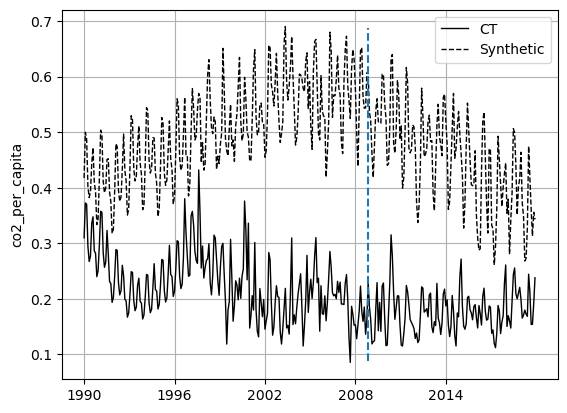

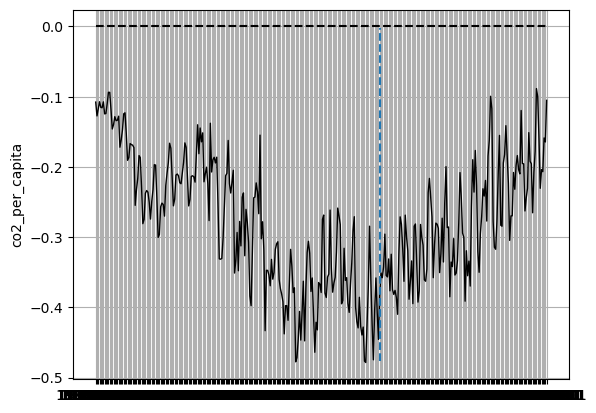

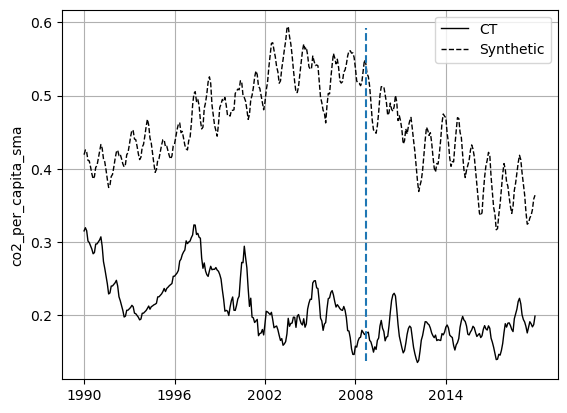

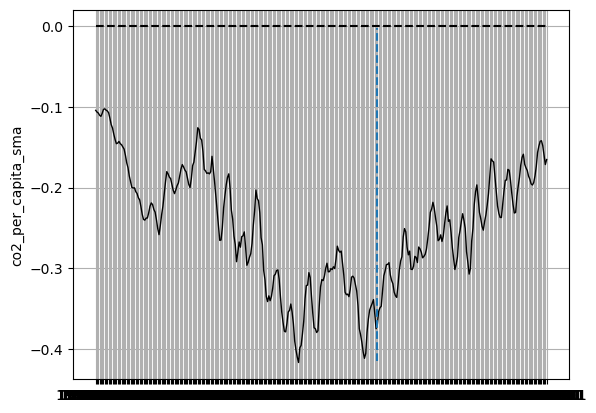

State: CT 

monthly_emissions version: 

OR    0.240
IL    0.432
MN    0.328
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.079   15.229     24.709       21.660
special.1.eprod_per_capita     0.114    0.005      0.008        0.064
special.2.eflow_per_capita     0.452   -0.015     -0.017        0.031
special.3.gdp_per_capita       0.026    0.006      0.004        0.004
special.4.monthly_pop_density  0.078    0.002      0.015        0.034
special.5.yearly_renew_pct     0.000    0.016      0.194        0.105
special.6.yearly_fossil_pct    0.252    0.461      0.491        0.729
monthly_emissions SMA version: 

OR    0.301
IL    0.260
MN    0.439
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.131   15.229     19.938       21.660
special.1.eprod_per_capita     0.022    0.005      0.007        0.064
special.2.eflow_per_

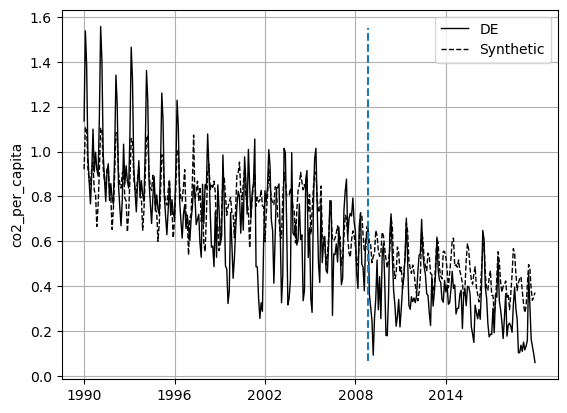

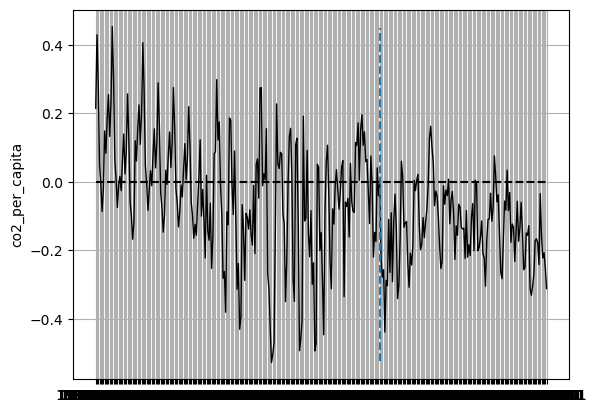

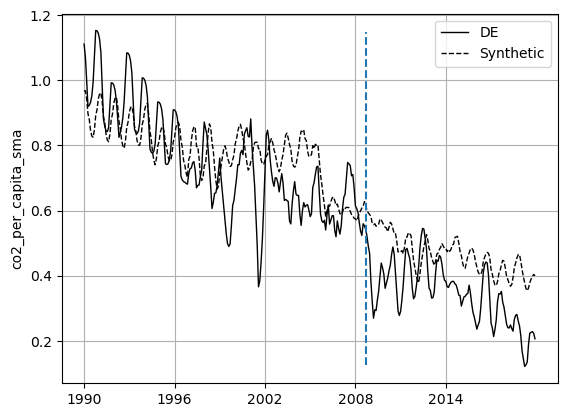

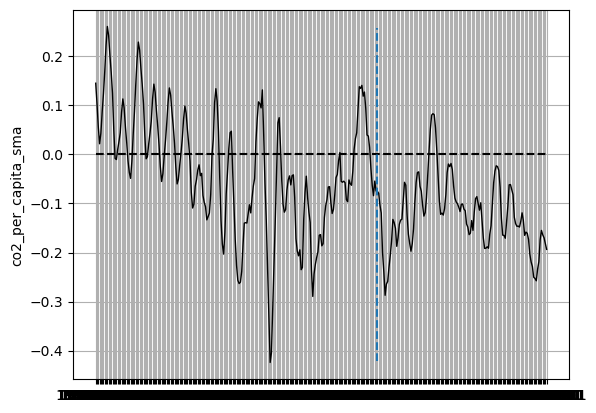

State: DE 

monthly_emissions version: 

NV    0.461
IL    0.118
MN    0.421
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.212    7.840     16.831       21.660
special.1.eprod_per_capita     0.181    0.000      0.004        0.064
special.2.eflow_per_capita     0.157   -0.030     -0.023        0.031
special.3.gdp_per_capita       0.130    0.006      0.005        0.004
special.4.monthly_pop_density  0.186    0.003      0.036        0.034
special.5.yearly_renew_pct     0.133    0.000      0.071        0.105
special.6.yearly_fossil_pct    0.000    0.963      0.750        0.729
monthly_emissions SMA version: 

NV    0.443
MN    0.557
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.233    7.840     14.267       21.660
special.1.eprod_per_capita     0.071    0.000      0.003        0.064
special.2.eflow_per_capita     0

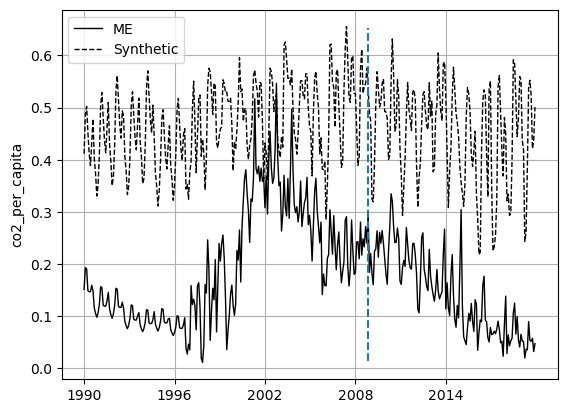

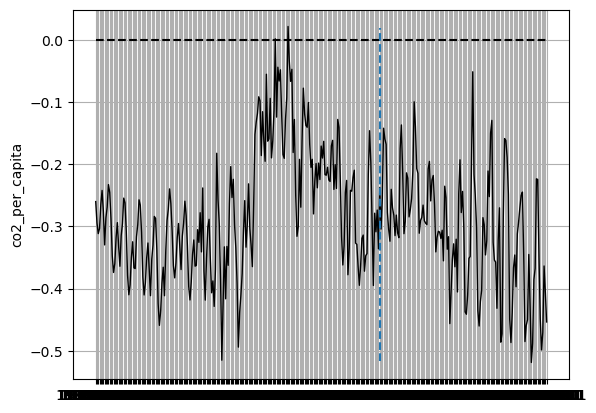

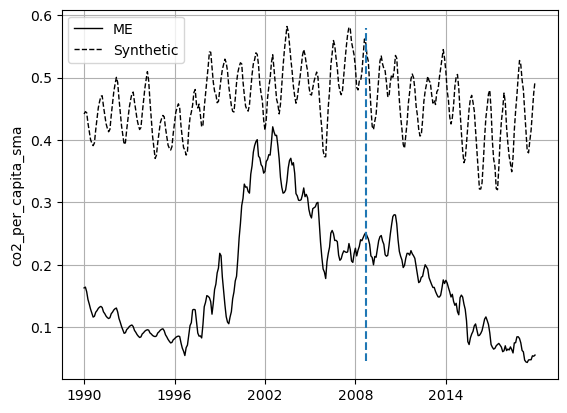

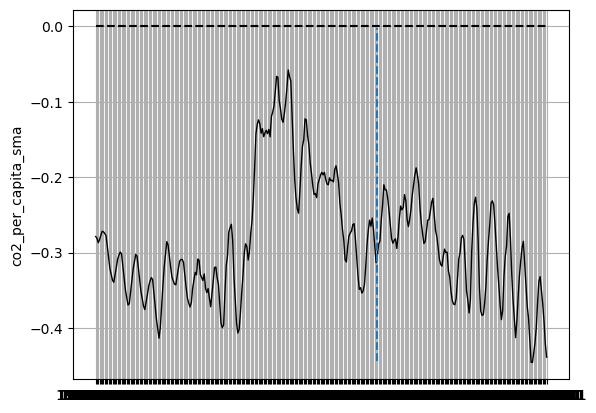

State: ME 

monthly_emissions version: 

OR    0.670
AR    0.180
TN    0.019
UT    0.132
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.161    4.479      6.003       21.660
special.1.eprod_per_capita     0.131    0.010      0.011        0.064
special.2.eflow_per_capita     0.160   -0.018     -0.012        0.031
special.3.gdp_per_capita       0.139    0.004      0.004        0.004
special.4.monthly_pop_density  0.194    0.028      0.029        0.034
special.5.yearly_renew_pct     0.000    0.240      0.525        0.105
special.6.yearly_fossil_pct    0.215    0.396      0.395        0.729
monthly_emissions SMA version: 

OR    0.668
AR    0.179
TN    0.024
UT    0.129
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.156    4.479      6.018       21.660
special.1.eprod_per_capita     0.138    0.010      0.011        0.

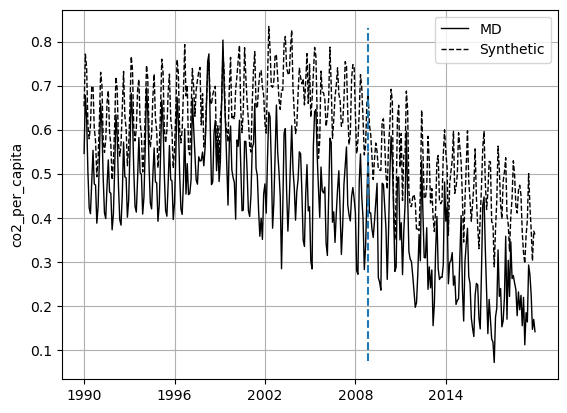

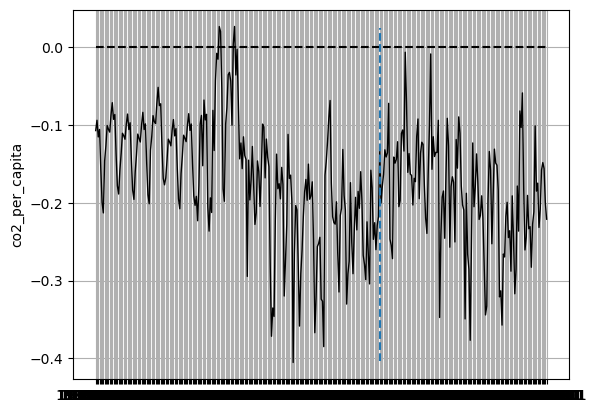

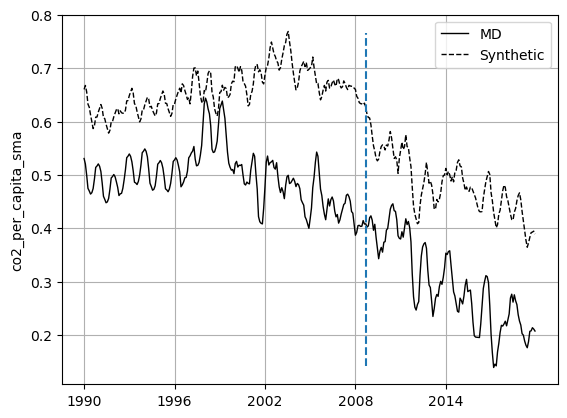

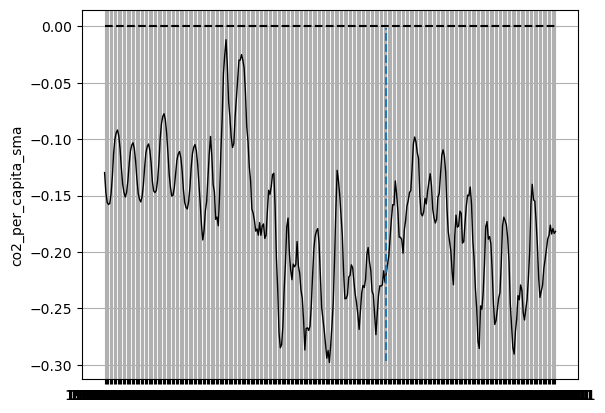

State: MD 

monthly_emissions version: 

TN    0.12
MN    0.88
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.083   13.000     17.089       21.660
special.1.eprod_per_capita     0.186    0.004      0.004        0.064
special.2.eflow_per_capita     0.155   -0.018     -0.025        0.031
special.3.gdp_per_capita       0.181    0.004      0.004        0.004
special.4.monthly_pop_density  0.036    0.002      0.017        0.034
special.5.yearly_renew_pct     0.212    0.038      0.044        0.105
special.6.yearly_fossil_pct    0.147    0.670      0.675        0.729
monthly_emissions SMA version: 

TN    0.12
MN    0.88
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.083   13.000     17.088       21.660
special.1.eprod_per_capita     0.186    0.004      0.004        0.064
special.2.eflow_per_capita     0.155   -0.018   

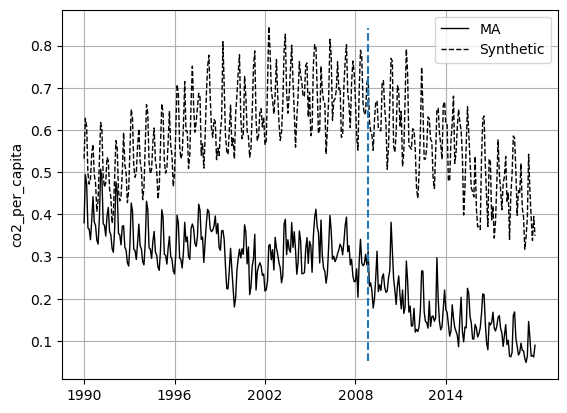

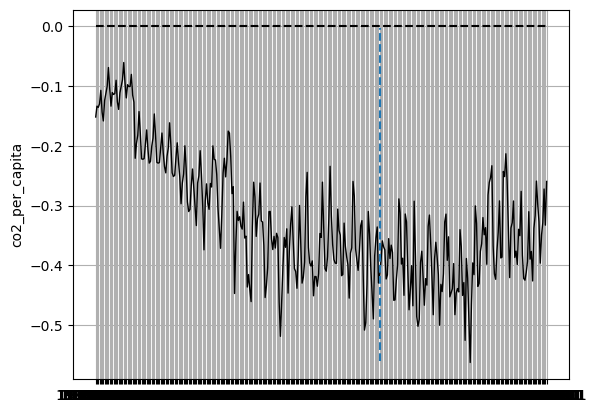

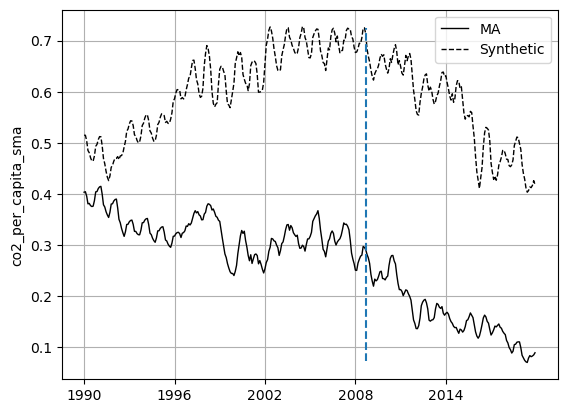

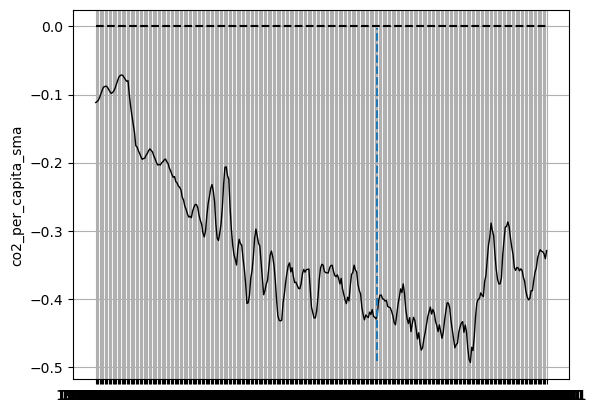

State: MA 

monthly_emissions version: 

IL    0.645
MN    0.355
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.092   26.167     32.868       21.660
special.1.eprod_per_capita     0.176    0.001      0.010        0.064
special.2.eflow_per_capita     0.046   -0.018     -0.017        0.031
special.3.gdp_per_capita       0.114    0.005      0.005        0.004
special.4.monthly_pop_density  0.352    0.002      0.009        0.034
special.5.yearly_renew_pct     0.219    0.024      0.014        0.105
special.6.yearly_fossil_pct    0.001    0.823      0.563        0.729
monthly_emissions SMA version: 

IL    0.809
MN    0.191
Name: weights, dtype: float64 

                                   V  treated  synthetic  sample mean
monthly_num_plants             0.031   26.167     36.636       21.660
special.1.eprod_per_capita     0.227    0.001      0.012        0.064
special.2.eflow_per_capita     0.082   -0.01

KeyboardInterrupt: 

In [48]:
# loop through all RGGI states to see their monthly graphs

for state in rggi_states:

    # monthly_emissions version

    dataprep_mo = Dataprep(
    foo=df_mo,
    predictors=['monthly_num_plants'], 
    predictors_op="mean",
    time_predictors_prior=preintervention_feature_range,
    special_predictors=[
        ('eprod_per_capita', preintervention_energy_range, "mean"),
        ('eflow_per_capita', preintervention_energy_range, "mean"),
        ('gdp_per_capita', preintervention_gdp_range, "mean"),
        ('monthly_pop_density', preintervention_per_capita_range, "mean"),
        ('yearly_renew_pct', preintervention_energy_range, "mean"),
        ('yearly_fossil_pct', preintervention_energy_range, "mean")
        ],
    dependent="co2_per_capita",
    unit_variable="state",
    time_variable="date",
    treatment_identifier=state,
    controls_identifier= non_rggi_controls_identifier,
    time_optimize_ssr=preintervention_time_range
    )

    # month_emissions SMA version

    dataprep_mo_ma = Dataprep(
        foo=df_mo,
        predictors=['co2_per_capita', 'monthly_num_plants'],
        predictors_op="mean",
        time_predictors_prior=preintervention_feature_range,
        special_predictors=[
            ('eprod_per_capita', preintervention_energy_range, "mean"),
            ('eflow_per_capita', preintervention_energy_range, "mean"),
            ('gdp_per_capita', preintervention_gdp_range, "mean"),
            ('monthly_pop_density', preintervention_per_capita_range, "mean"),
            ('yearly_renew_pct', preintervention_energy_range, "mean"),
            ('yearly_fossil_pct', preintervention_energy_range, "mean")
            ],
        dependent="co2_per_capita_sma",
        unit_variable="state",
        time_variable="date",
        treatment_identifier=state,
        controls_identifier= non_rggi_controls_identifier,
        time_optimize_ssr=preintervention_ma_range
        )
    
    # monthly_emissions version

    synth_mo = Synth()
    synth_mo.fit(dataprep=dataprep_mo)

    synth_mo.path_plot(time_period=years, treatment_time=treatment_dates[0])
    synth_mo.gaps_plot(time_period=years, treatment_time=treatment_dates[0])
    
    # monthly_emissions SMA version
    
    synth_mo_ma = Synth()
    synth_mo_ma.fit(dataprep=dataprep_mo_ma)

    synth_mo_ma.path_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])
    synth_mo_ma.gaps_plot(time_period=years_sma, treatment_time=treatment_dates_ma[0])

    print('State:', state,'\n')
    print('monthly_emissions version:','\n')
    print(synth_mo.weights(threshold=.01),'\n')
    print(synth_mo.summary())
    print('monthly_emissions SMA version:','\n')
    print(synth_mo_ma.weights(threshold=.01),'\n')
    print(synth_mo_ma.summary())